import the necessary packages

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

initialize the initial learning rate, number of epochs to train for,<br>
and batch size

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
DIRECTORY = "../fmd/dataset/"
CATEGORIES = ["with_mask", "without_mask"]

grab the list of images in our dataset directory, then initialize<br>
the list of data (i.e., images) and class images

In [4]:
print("[INFO] loading images...")

[INFO] loading images...


In [5]:
data = []
labels = []

In [6]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)
    	data.append(image)
    	labels.append(category)

C:\all softwares\Anaconda\Anaconda\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


perform one-hot encoding on the labels

In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [8]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [9]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

construct the training image generator for data augmentation

In [10]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

load the MobileNetV2 network, ensuring the head FC layer sets are<br>
left off

In [11]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

construct the head of the model that will be placed on top of the<br>
the base model

In [12]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

place the head FC model on top of the base model (this will become<br>
the actual model we will train)

In [13]:
model = Model(inputs=baseModel.input, outputs=headModel)

loop over all layers in the base model and freeze them so they will<br>
*not* be updated during the first training process

In [15]:
for layer in baseModel.layers:
	layer.trainable = False

compile our model

In [16]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


C:\Users\kisho\AppData\Roaming\Python\Python38\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


train the head of the network

In [17]:
print("[INFO] training head...")
H = model.fit(
aug.flow(trainX, trainY, batch_size=BS),
steps_per_epoch=len(trainX) // BS,
validation_data=(testX, testY),
validation_steps=len(testX) // BS,epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 61s 611ms/step - loss: 0.4756 - accuracy: 0.8115 - val_loss: 0.1944 - val_accuracy: 0.9791
Epoch 2/20
95/95 [==============================] - 66s 699ms/step - loss: 0.1717 - accuracy: 0.9601 - val_loss: 0.0864 - val_accuracy: 0.9883
Epoch 3/20
95/95 [==============================] - 72s 758ms/step - loss: 0.1099 - accuracy: 0.9740 - val_loss: 0.0624 - val_accuracy: 0.9857
Epoch 4/20
95/95 [==============================] - 75s 787ms/step - loss: 0.0856 - accuracy: 0.9763 - val_loss: 0.0471 - val_accuracy: 0.9896
Epoch 5/20
95/95 [==============================] - 73s 769ms/step - loss: 0.0678 - accuracy: 0.9819 - val_loss: 0.0416 - val_accuracy: 0.9909
Epoch 6/20
95/95 [==============================] - 73s 763ms/step - loss: 0.0560 - accuracy: 0.9881 - val_loss: 0.0368 - val_accuracy: 0.9922
Epoch 7/20
95/95 [==============================] - 73s 765ms/step - loss: 0.0574 - accuracy: 0.9845 - val_loss: 0.036

make predictions on the testing set

In [18]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
24/24 [==============================] - 10s 377ms/step


for each image in the testing set we need to find the index of the<br>
label with corresponding largest predicted probability

In [19]:
predIdxs = np.argmax(predIdxs, axis=1)

show a nicely formatted classification report

In [20]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



serialize the model to disk

In [21]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


plot the training loss and accuracy

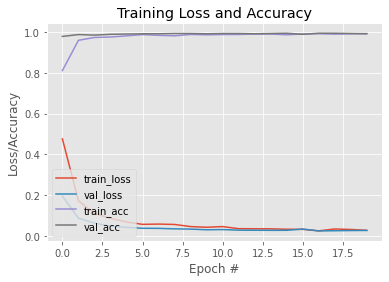

In [22]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")